In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 		#to normalize data
from custom_objects import LSTMModel, smape

2024-06-05 10:50:49.127940: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-05 10:50:49.182687: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 10:50:50.144754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Standard scalar normalization
def normalize_data(df, model):
    cols_normalize = df.columns.difference(['id','time_cycles','RUL'])
    norm_df = pd.DataFrame(model.scaler.transform(df[cols_normalize]),
                             columns=cols_normalize,
                             index=df.index)
    join_df = df[df.columns.difference(cols_normalize)].join(norm_df)
    df = join_df.reindex(columns = df.columns)
    return df
        
# Data ETL
def etl(df_path, model, ids):
    index_names = ['id', 'time_cycles']
    setting_names = ['setting_1', 'setting_2', 'setting_3']
    sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
    col_names = index_names + setting_names + sensor_names
        
    try:
        df = pd.read_csv(df_path,sep='\s+',header=None,index_col=False,names=col_names)
    except:
        print("No file was found or it's structure is not as expected")
        
    df = df[df['id'].isin(ids)]
    df = df.sort_values(['id','time_cycles'])
    
    # drop the constants features and the settings based on the EDA
    list_columns_droped = ['setting_1', 'setting_2', 'setting_3', 's_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']
    df.drop(columns=list_columns_droped, inplace=True)
        
    # data normalization
    # it needs to use the saved model
    df = normalize_data(df, model)
        
    print("ETL completed!")
    return df
    
# Production real RUL
def pred_RUL(df, ids):
    y_true = pd.read_csv('../dataset/CMaps/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    idx = [x - 1 for x in ids]
    y_true = y_true['RUL'].iloc[idx].tolist()
    
    m = df.groupby('id')['time_cycles'].max()
    r = [x + y for x, y in zip(m.tolist(), y_true)]

    rul = pd.DataFrame({'id': ids,'max': r,}).reset_index()
    df = df.merge(rul, on=['id'], how='left')
    df['RUL'] = df['max'] - df['time_cycles']
    return df['RUL'].tolist()

In [3]:
model_path = '../trained_models/lstm_pipeline_v2_2024-06-05_09_00_10.pkl'
test_path  = '../dataset/CMaps/test_FD001.txt'

with open(model_path, 'rb') as file:
    lstm_model = pickle.load(file)

ids = [31, 34, 35, 36, 66, 68, 76, 81, 82, 100]
looking_back = 5

df_test = etl(test_path, lstm_model, ids)
y_test  = pred_RUL(df_test, ids)

x_test =np.concatenate(list(list(lstm_model.get_window(df_test[df_test['id']==unit], looking_back, lstm_model.features)) for unit in df_test['id'].unique()))
y_pred = lstm_model.model.predict(x_test, verbose=0)

2024-06-05 10:50:53.175257: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-05 10:50:53.436223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-05 10:50:53.439003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-05 10:50:53.440499: I tensorflow/core/com

ETL completed!


2024-06-05 10:50:54.110235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-05 10:50:54.112614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-05 10:50:54.113896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

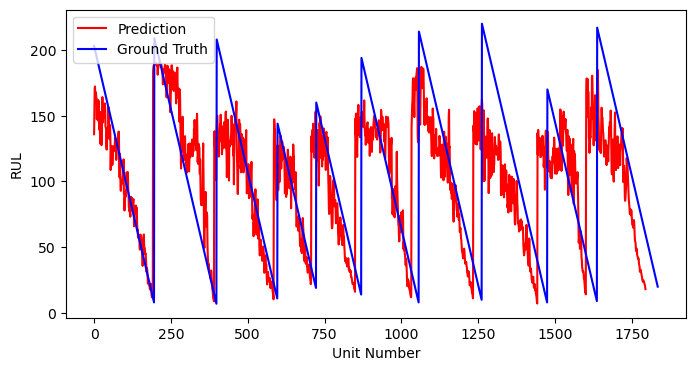

In [4]:
plt.figure(figsize=(8,4))
plt.plot(y_pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()